# Assignment 4 
- Aman Joshi 2018201097

In [ ]:
import sys
import numpy as np
import cv2 as cv
import igraph
from matplotlib import pyplot as plt
from copy import deepcopy
import os
from gaussian import GaussianMixture

In [ ]:
BG = 0
FG = 1
PR_BG = 2
PR_FG = 3

## Grabcut
- We give a bounding box. 
- Assign GMM components to pixels
- Learn GMM parameters from data
- Make graph(n-links between pixels and t-links between source, sink and pixels)
- Estimate segmentation: use min cut to solve
- Repeat the process

## Class GrabCut
- It has function for calculating beta.
- Assigning GMM and calculating component for each pixel.
- Modelling Graph
- Estimate Segmentation

## Implementation Details
- I have used Gaussian Mixture code from github
- For making graph I have used igraph package
- Once we have gaussian trained we make graph.
- Then we calculate mincut.
- the process is repeated

In [29]:
class GrabCut:
    def __init__(self, img, mask, rect=None, gmm_components=5, neighbours=8):
        self.img = np.asarray(img, dtype=np.float64)
        self.out_image = deepcopy(img)
        self.rows, self.cols, _ = img.shape
        self.mask = mask
        self.neighbours = neighbours
        
        if rect is not None:
            self.mask[rect[1]:rect[1] + rect[3], rect[0]:rect[0] +
                      rect[2]] = PR_FG

        self.classify_pixels()

        self.gmm_components = gmm_components
        self.gamma = 50
        self.calculate_beta_smoothness()

        self.fgd_gmm = GaussianMixture(self.img[self.fgd_indexes])
        self.bgd_gmm = GaussianMixture(self.img[self.bgd_indexes])
        self.label_gmm = np.empty((self.rows, self.cols), dtype=np.uint32)

        self.gc_source = self.cols * self.rows  # "object" terminal S
        self.gc_sink = self.gc_source + 1  # "background" terminal T

    def calculate_beta_smoothness(self):
        left_diff = self.img[:, 1:] - self.img[:, :-1]
        up_left_diff = self.img[1:, 1:] - self.img[:-1, :-1]
        up_diff = self.img[1:, :] - self.img[:-1, :]
        up_right_diff = self.img[1:, :-1] - self.img[:-1, 1:]

        self.beta = np.linalg.norm(left_diff)**2 + np.linalg.norm(up_diff)**2
        if self.neighbours == 8:
            self.beta += np.linalg.norm(up_left_diff)**2 + np.linalg.norm(
                up_right_diff)**2
        #         self.beta = np.sum(np.square(left_diff)) + np.sum(np.square(up_left_diff)) + \
        #             np.sum(np.square(up_diff)) + \
        #             np.sum(np.square(up_right_diff))
        if self.neighbours == 8:
            self.beta = 2.0 * self.beta / (4 * self.rows * self.cols - 3 *
                                           (self.rows + self.cols) + 2.0)
        else:
            self.beta = 2.0 * self.beta / (2 * self.rows * self.cols - 1 *
                                           (self.rows + self.cols) + 2.0)
        self.beta = 1 / self.beta

        #         print(self.beta)

        def calculate_V(x):
            return self.gamma * np.exp(
                -self.beta * np.sum(np.square(x), axis=2))

        self.left_V = calculate_V(left_diff)
        self.up_left_V = calculate_V(up_left_diff)
        self.up_V = calculate_V(up_diff)
        self.up_right_V = calculate_V(up_right_diff)

    def classify_pixels(self):
        self.fgd_indexes = np.where((self.mask == FG) | (self.mask == PR_FG))
        self.bgd_indexes = np.where((self.mask == BG) | (self.mask == PR_BG))

    def assign_GMM(self):
        self.label_gmm[self.fgd_indexes] = self.fgd_gmm.which_component(
            self.img[self.fgd_indexes])
        self.label_gmm[self.bgd_indexes] = self.bgd_gmm.which_component(
            self.img[self.bgd_indexes])

    def learn_GMM(self):
        self.fgd_gmm.fit(self.img[self.fgd_indexes],
                         self.label_gmm[self.fgd_indexes])
        self.bgd_gmm.fit(self.img[self.bgd_indexes],
                         self.label_gmm[self.bgd_indexes])

    def make_n_links(self, mask1, mask2, V):
        mask1 = mask1.reshape(-1)
        mask2 = mask2.reshape(-1)
        self.gc_graph_capacity += V.reshape(-1).tolist()
        return list(zip(mask1, mask2))

    def construct_gc_graph(self):
        fgd_indexes = np.where(self.mask.reshape(-1) == FG)
        bgd_indexes = np.where(self.mask.reshape(-1) == BG)
        pr_indexes = np.where((self.mask.reshape(-1) == PR_FG)
                              | (self.mask.reshape(-1) == PR_BG))

        self.gc_graph_capacity = []
        edges = []

        def make_edges(source, sinks):
            return list(zip([source] * sinks[0].size, sinks[0]))

        edges += make_edges(self.gc_source, pr_indexes)
        self.gc_graph_capacity += list(-np.log(
            self.bgd_gmm.calc_prob(self.img.reshape(-1, 3)[pr_indexes])))

        edges += make_edges(self.gc_sink, pr_indexes)
        self.gc_graph_capacity += list(-np.log(
            self.fgd_gmm.calc_prob(self.img.reshape(-1, 3)[pr_indexes])))

        edges += make_edges(self.gc_source, fgd_indexes)
        self.gc_graph_capacity += [9 * self.gamma] * fgd_indexes[0].size

        edges += make_edges(self.gc_sink, fgd_indexes)
        self.gc_graph_capacity += [0] * fgd_indexes[0].size

        edges += make_edges(self.gc_source, bgd_indexes)
        self.gc_graph_capacity += [0] * bgd_indexes[0].size

        edges += make_edges(self.gc_sink, bgd_indexes)
        self.gc_graph_capacity += [9 * self.gamma] * bgd_indexes[0].size

        img_indexes = np.arange(
            self.rows * self.cols, dtype=np.uint32).reshape(
                self.rows, self.cols)

        edges += self.make_n_links(img_indexes[:, 1:], img_indexes[:, :-1],
                                   self.left_V)
        edges += self.make_n_links(img_indexes[1:, :], img_indexes[:-1, :],
                                   self.up_V)
        if self.neighbours == 8:
            edges += self.make_n_links(img_indexes[1:, 1:],
                                       img_indexes[:-1, :-1], self.up_left_V)
            edges += self.make_n_links(img_indexes[1:, :-1],
                                       img_indexes[:-1, 1:], self.up_right_V)

        assert (len(edges) == len(self.gc_graph_capacity))

        self.gc_graph = igraph.Graph(self.rows * self.cols + 2)
        self.gc_graph.add_edges(edges)

    def estimate_segmentation(self):
        mincut = self.gc_graph.st_mincut(self.gc_source, self.gc_sink,
                                         self.gc_graph_capacity)
        print('foreground pixels: %d, background pixels: %d' % (len(
            mincut.partition[0]), len(mincut.partition[1])))
        pr_indexes = np.where((self.mask == PR_FG) | (self.mask == PR_BG))
        img_indexes = np.arange(
            self.rows * self.cols, dtype=np.uint32).reshape(
                self.rows, self.cols)
        condition = np.isin(img_indexes[pr_indexes], mincut.partition[0])
        self.mask[pr_indexes] = np.where(condition, PR_FG, PR_BG)
        self.classify_pixels()

    def modified_image(self, img2=None):
        if img2 is None:
            img2 = deepcopy(self.out_image)
        mask = self.mask.copy()
        mask2 = np.where((self.mask == 1) + (self.mask == 3), 255,
                         0).astype('uint8')
        return cv.bitwise_and(img2, img2, mask=mask2)

    def run(self, num_iters=2):
        for _ in range(num_iters):
            self.assign_GMM()
            self.learn_GMM()
            self.construct_gc_graph()
            self.estimate_segmentation()


#             print("Image after iteration {0}".format(_))
#             plt.imshow(self.modified_image())
#             plt.show()

#             cv.imshow("Image after Iteration {0}".format(_),
#                       self.modified_image())
#             cv.waitKey(0)
#             cv.destroyAllWindows()

In [ ]:
def fun(image_path, filename):
    image = cv.imread(image_path)
    f = open(filename, 'r')
    rect = list(f.readline().split())
    rect = [int(i) for i in rect]
    f.close()
    gg = GrabCut(image, np.zeros(image.shape[:2], dtype=np.uint8), rect)
    cv.rectangle(image, (16, 20), (620, 436), (255, 0, 0), 2)
    plt.imshow(image)
    plt.show()
    #     cv.waitKey(0)
    #     cv.destroyAllWindows()
    gg.run()
    plt.imshow(gg.modified_image())
    plt.show()

In [ ]:
image_list = ["images/" + file for file in os.listdir('images')]
box_list = ["bboxes/" + file for file in os.listdir('bboxes')]
image_list.sort()
box_list.sort()
for image_path, filename in zip(image_list, box_list):
    fun(image_path, filename)

## Various Colour Spaces

In [5]:
image = cv.imread("images/sheep.jpg")
rect = (171, 171, 309, 386)

In [6]:
def run_on_image(image, rect, image2):
    gg = GrabCut(image, np.zeros(image.shape[:2], dtype=np.uint8), rect)
    gg.run()
    plt.imshow(gg.modified_image(image2))
    plt.show()

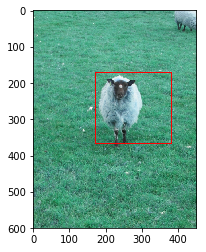

RGB
0.0007559501106342182
foreground pixels: 15094, background pixels: 254908
foreground pixels: 14954, background pixels: 255048


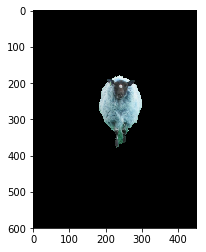

HSV
0.0011274896151577947
foreground pixels: 15119, background pixels: 254883
foreground pixels: 15120, background pixels: 254882


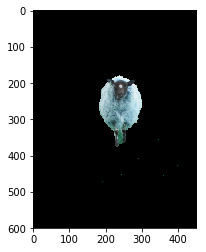

YUV
0.002256453222115342
foreground pixels: 15023, background pixels: 254979
foreground pixels: 14626, background pixels: 255376


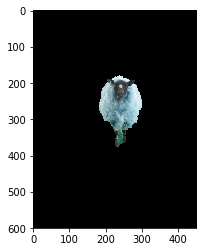

In [7]:
II = deepcopy(image)
cv.rectangle(II, (171, 171), (380, 366), (255, 0, 0), 2)
plt.imshow(II)
plt.show()
print("RGB")
run_on_image(image, rect, image)
print("HSV")
run_on_image(cv.cvtColor(image, cv.COLOR_BGR2HSV), rect, image)
print("YUV")
run_on_image(cv.cvtColor(image, cv.COLOR_BGR2YUV), rect, image)

## Observations:
- There is not much differnce by changing the color space
- Although there can be cases where changing the color space will change the result

## Number of Iterations

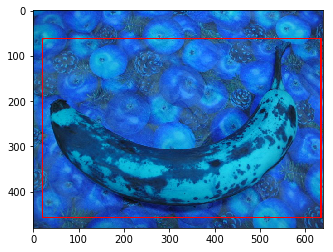

0.0021199558038790126
foreground pixels: 113424, background pixels: 193778
Image after iteration 0


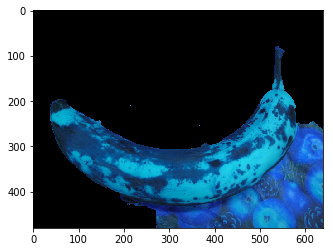

foreground pixels: 87270, background pixels: 219932
Image after iteration 1


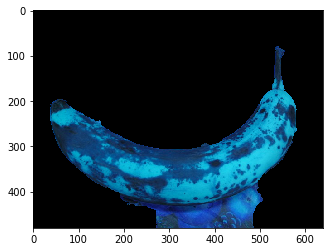

foreground pixels: 73191, background pixels: 234011
Image after iteration 2


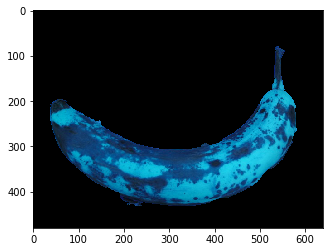

foreground pixels: 72505, background pixels: 234697
Image after iteration 3


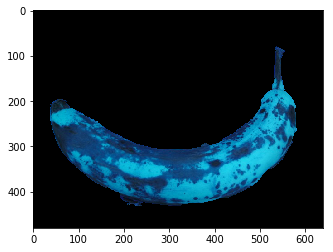

foreground pixels: 72097, background pixels: 235105
Image after iteration 4


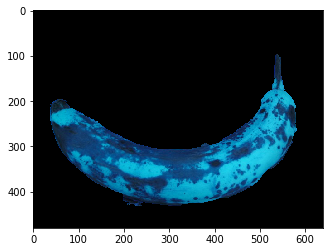

In [17]:
II = deepcopy(image)
cv.rectangle(II, (20, 62), (635, 456), (255, 0, 0), 2)
plt.imshow(II)
plt.show()
image = cv.imread("images/banana2.jpg")
rect = (20, 62, 635, 426)
gg = GrabCut(image, np.zeros(image.shape[:2], dtype=np.uint8), rect)
gg.run(5)

## Obseravations:
- With increasing the number of iterations the image is getting better.
- however with increasing iteration the improvement is very less.
- After 3rd iteration there is not much visible difference.

## Number of Components in GMM

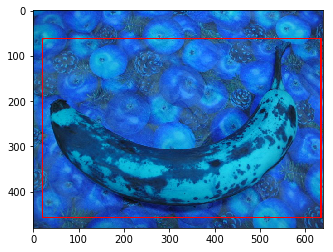

0.0021199558038790126
foreground pixels: 113424, background pixels: 193778
foreground pixels: 87270, background pixels: 219932
foreground pixels: 73191, background pixels: 234011


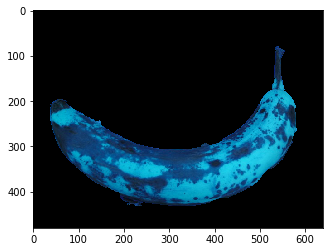

0.0021199558038790126
foreground pixels: 113424, background pixels: 193778
foreground pixels: 87270, background pixels: 219932
foreground pixels: 73191, background pixels: 234011


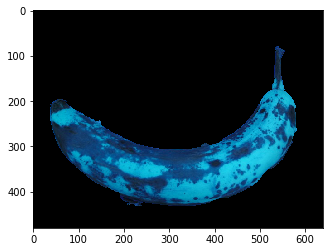

0.0021199558038790126
foreground pixels: 113425, background pixels: 193777
foreground pixels: 87270, background pixels: 219932
foreground pixels: 73191, background pixels: 234011


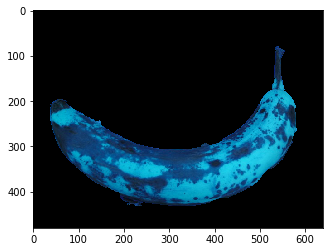

0.0021199558038790126
foreground pixels: 116383, background pixels: 190819
foreground pixels: 87277, background pixels: 219925
foreground pixels: 81438, background pixels: 225764


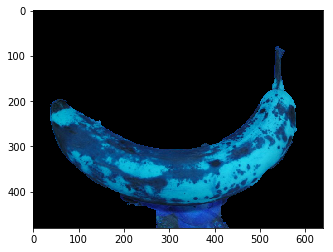

In [23]:
image = cv.imread("images/banana2.jpg")
rect = (20, 62, 635, 426)
II = deepcopy(image)
cv.rectangle(II, (20, 62), (635, 456), (255, 0, 0), 2)
plt.imshow(II)
plt.show()
for components in [2, 3, 5, 8]:
    gg = GrabCut(image, np.zeros(image.shape[:2], dtype=np.uint8), rect,
                 components)
    gg.run(3)
    plt.imshow(gg.modified_image())
    plt.show()

## Observations
- For fewer number of GMM's the grab cut is quite perfect.
- For 8 component the grab cut is comparitevely poorer.
- One reason can be that the distribution is better modelled for less number of components.

## 4 Neighbourhood vs 8 Neighbourhood

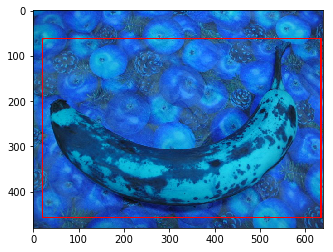

foreground pixels: 93906, background pixels: 213296
foreground pixels: 79883, background pixels: 227319
foreground pixels: 76597, background pixels: 230605


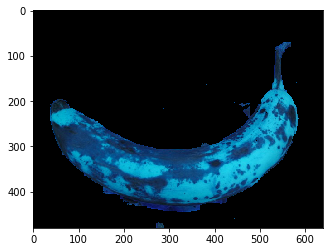

foreground pixels: 113423, background pixels: 193779
foreground pixels: 87271, background pixels: 219931
foreground pixels: 73190, background pixels: 234012


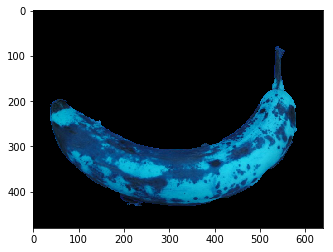

In [30]:
image = cv.imread("images/banana2.jpg")
rect = (20, 62, 635, 426)
II = deepcopy(image)
cv.rectangle(II, (20, 62), (635, 456), (255, 0, 0), 2)
plt.imshow(II)
plt.show()
gg = GrabCut(image, np.zeros(image.shape[:2], dtype=np.uint8), rect,
                 neighbours=4)
gg.run(3)
plt.imshow(gg.modified_image())
plt.show()
gg = GrabCut(image, np.zeros(image.shape[:2], dtype=np.uint8), rect)
gg.run(3)
plt.imshow(gg.modified_image())
plt.show()

## Observations:
- The grab cut is better for 8 neighbour.
- More neighbour is making the graph comapritevely dense thus resulting in better cut.
- More nlinks means the contribution of smoothness in total cost increases.